# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import os
from skimage.transform import resize
from random import shuffle
import pandas as pd
import cv2
from collections import Counter
from skimage import exposure
from sklearn.utils import shuffle as shuffle_X_y

data_dir = './data'

In [4]:
import pickle

# TODO: Fill this in based on where you saved the training and testing data
traffic_signs_data_dir = "%s/traffic-signs-data" % data_dir
training_file =  '%s/train.p' % traffic_signs_data_dir
validation_file = '%s/valid.p' % traffic_signs_data_dir
testing_file = '%s/test.p' % traffic_signs_data_dir
    
# Load pickled data
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

In [5]:
signnames_pd = pd.read_csv('signnames.csv')
signnames_pd.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [6]:
def signname_val_to_name(signnames_pd, val):
    return signnames_pd[signnames_pd['ClassId'] == val]['SignName'].values[0]

In [7]:
def make_label_image_dict(X, y):
    image_dict = {}
    
    for i in range(X.shape[0]):
        curr_image = X[i]
        curr_y = y[i]
        
        if curr_y in image_dict:
            image_dict[curr_y].append(curr_image)
        else:
            image_dict[curr_y] = [curr_image]
    
    return image_dict

In [8]:
def filter_images_by_label(label, X=None, y=None, label_image_dict=None):
    assert (X is not None and y is not None) or (label_image_dict is not None)
    
    filtered_image_arr = []

    if label_image_dict is None:
        label_image_dict = make_label_image_dict(X, y) 
        
    if label in label_image_dict:
        filtered_image_arr = label_image_dict[label]    
        return np.stack(filtered_image_arr)
    else:
        return None

In [9]:
def apply_to_layers(image, apply_fnc):
    image_arr = [apply_fnc(image[i]) for i in range(image.shape[0])]
    
    return np.stack(image_arr)

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [10]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = (X_train.shape[1], X_train.shape[2])

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train.reshape((-1)).tolist()))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [11]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

In [12]:
def display_X_y_images(X, y=None, signnames_pd=None, start_idx=0, end_idx=None, 
                       columns = 5, use_gray=False, apply_fnc=None):
    if end_idx is None:
        end_idx = X.shape[0]
        
    if apply_fnc is None:
        apply_fnc = lambda image: image
        
    plt.figure(figsize=(32,18))

    num_of_images = end_idx - start_idx
    rows = num_of_images / columns + 1
    
    for i in range(start_idx, end_idx):
        image = X[i]
        
        _i = i % num_of_images
        plt.subplot(rows, columns, _i + 1)
        
        if y is None or signnames_pd is None or y[i] == -1:
            title = 'Unlabeled'
        else:
            title = "%d: %s" % (y[i],
                                signnames_pd.loc[signnames_pd['ClassId']==y[i]]['SignName'].values[0])
            
        plt.title(title)
        
        if use_gray:
            plt.imshow(apply_fnc(image), cmap="gray")
        else:
            plt.imshow(apply_fnc(image)) 
            
    plt.tight_layout()
            
    plt.show()

### Sample images

Here are 30 sample images from the training set.

In [13]:
X_train, y_train = shuffle_X_y(X_train, y_train)

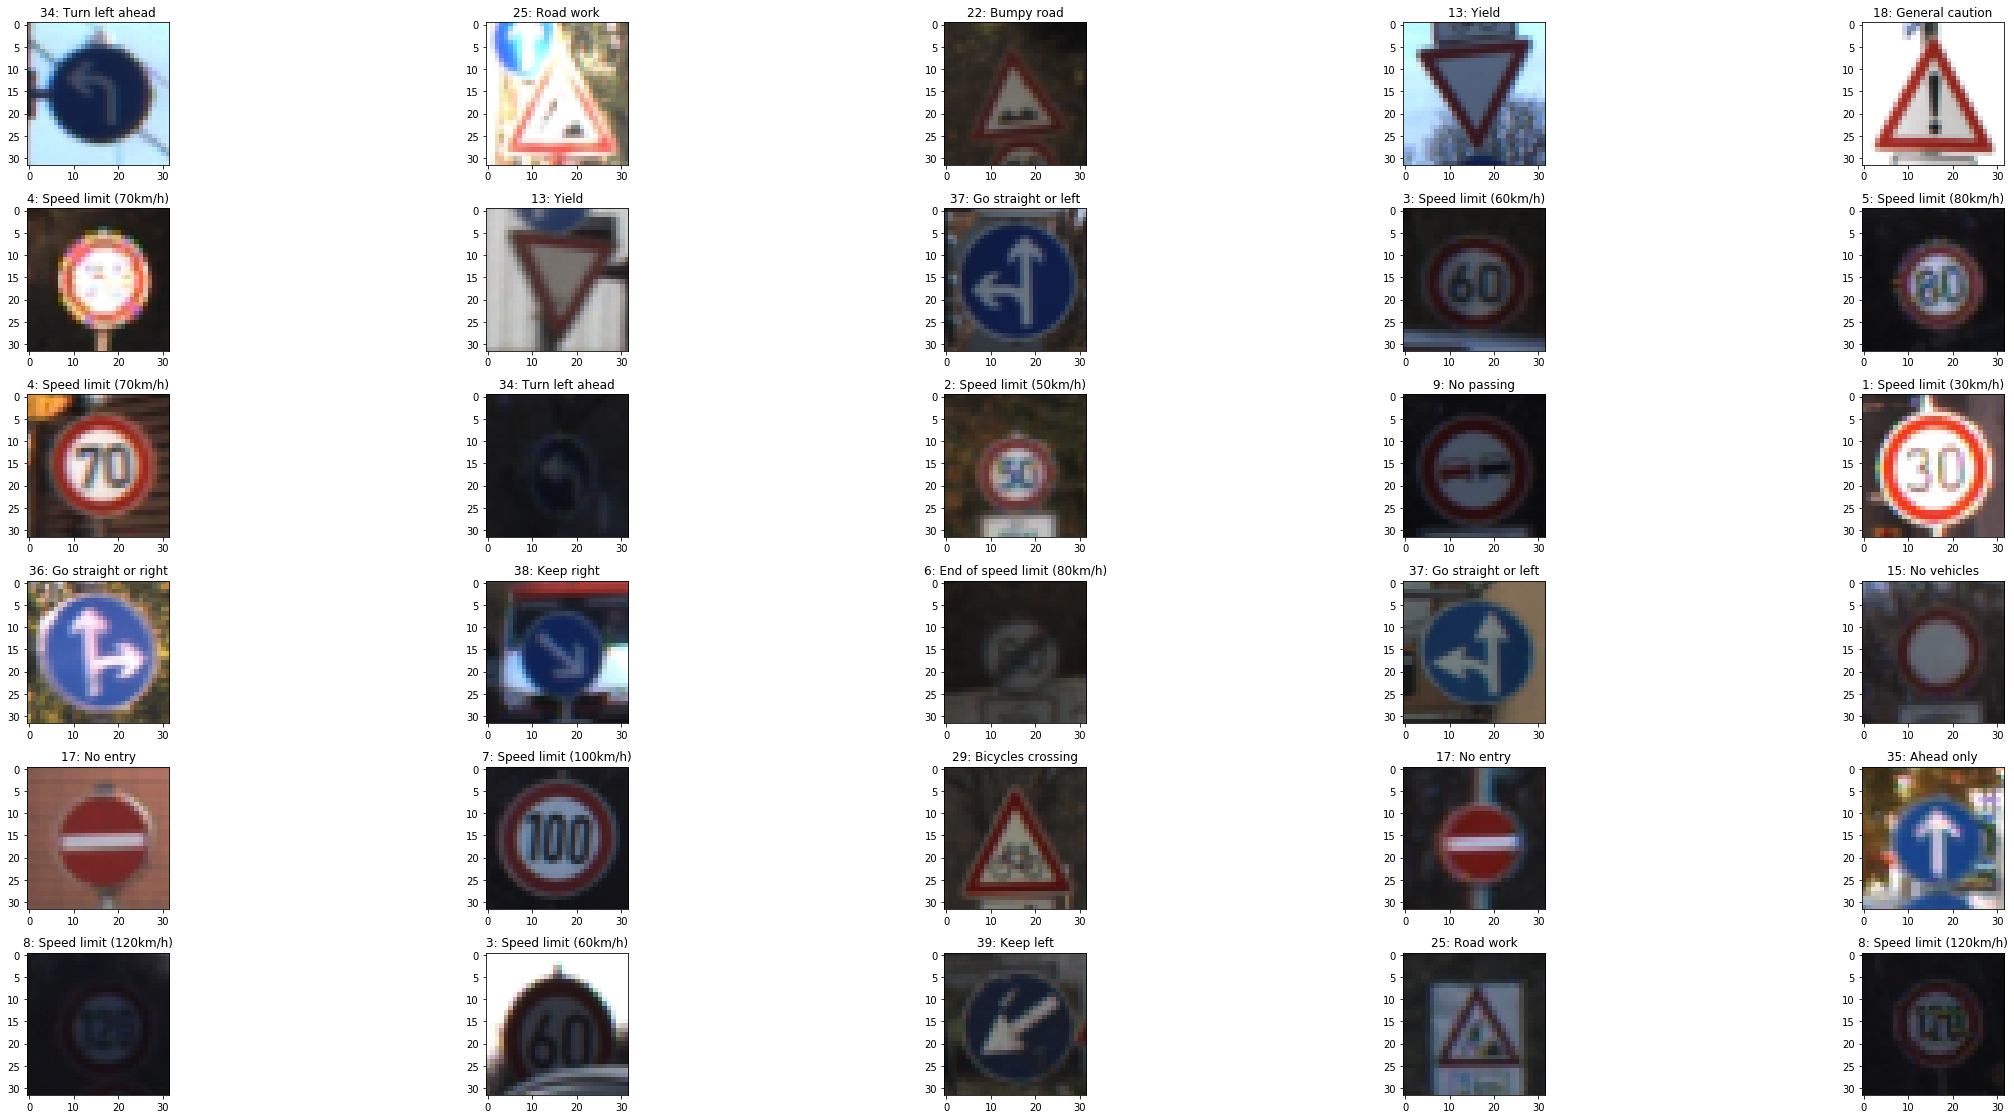

In [14]:
display_X_y_images(X_train, y_train, signnames_pd, start_idx=0, end_idx=30)

### Distribution of Training Images by Label

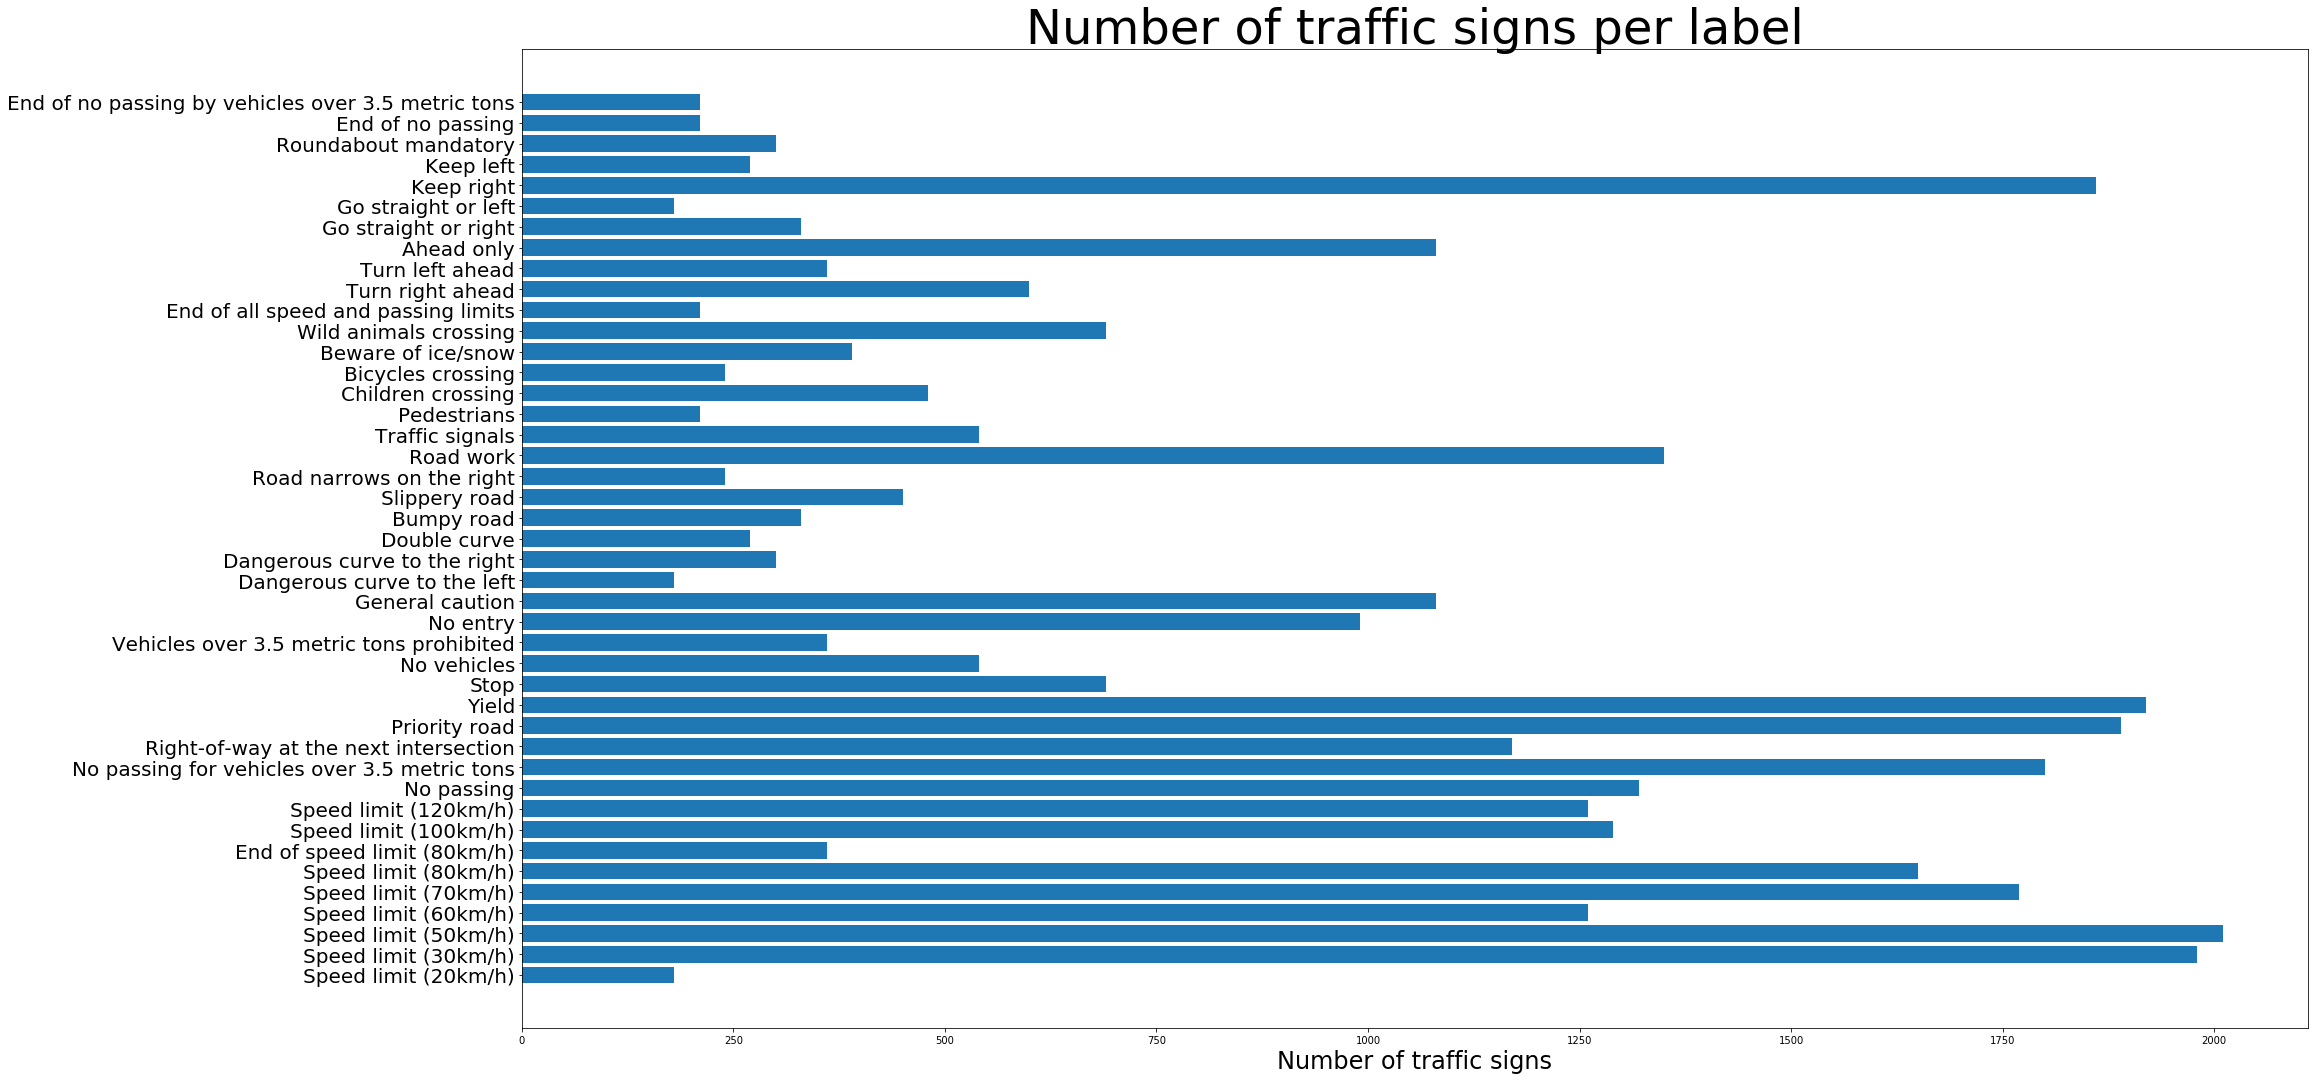

In [15]:
label_cnts = Counter(y_train)

x_vals = [x for x, _ in label_cnts.items()]
y_vals = [y for _, y in label_cnts.items()]    

plt.figure(figsize=(32,18))

plt.barh(x_vals, y_vals)
plt.title("Number of traffic signs per label").set_fontsize(48)
plt.yticks(x_vals, [signname_val_to_name(signnames_pd, val) for val in x_vals], fontsize = 20)
plt.xlabel('Number of traffic signs').set_fontsize(24)
plt.show()

In [16]:
label_cnt_arr = label_cnts.most_common(43)
least_common_label, least_common_cnt = label_cnt_arr[-1]
least_common_label_name = signname_val_to_name(signnames_pd, least_common_label)

most_common_label, most_common_cnt = label_cnt_arr[0]
most_common_label_name = signname_val_to_name(signnames_pd, most_common_label)

print("Label with least number of examples: (%d)%s - %d" % (least_common_label, least_common_label_name, 
                                                            least_common_cnt))
print("Label with most number of examples: (%d)%s - %d" % (most_common_label, most_common_label_name, 
                                                            most_common_cnt))

Label with least number of examples: (37)Go straight or left - 180
Label with most number of examples: (2)Speed limit (50km/h) - 2010


We can see that distribution of the examples are imbalanced.  Later, the data will be augmented to balance the examples for each label.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [17]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

# Augment data

For the training data, the numbers of images per label are not even.  Augment the data by randomly choosing images with replacement then applying one of the following transformations:

1. Rotate
2. Shift
3. Shear

In [18]:
from skimage.transform import rotate, AffineTransform, warp
from random import uniform, randrange
import cv2

def apply_random_rotate(image, min_angle=-20.0, max_angle=20.0):
    random_angle = uniform(min_angle, max_angle)
    
    return (255.0*rotate(image, random_angle)).astype(np.uint8)

def apply_random_shift(image, min_x_shift=-5, max_x_shift=5, 
                        min_y_shift=-5, max_y_shift=5):
    x_shift = randrange(min_x_shift, max_x_shift)
    y_shift = randrange(min_y_shift, max_y_shift)
    
    cols,rows = image.shape[0], image.shape[1]
    
    M = np.float32([[1,0,x_shift],[0,1,y_shift]])
    return cv2.warpAffine(image,M,(cols,rows))

def apply_random_shear(image, min_shear=-0.2, max_shear=0.2):
    shear = uniform(min_shear, max_shear)
    
    # Create Afine transform
    afine_tf = AffineTransform(shear=shear)

    # Apply transform to image data
    return warp(image, inverse_map=afine_tf)

### Rotate

The range for the rotate is from -20.0 to 20.0 degrees.

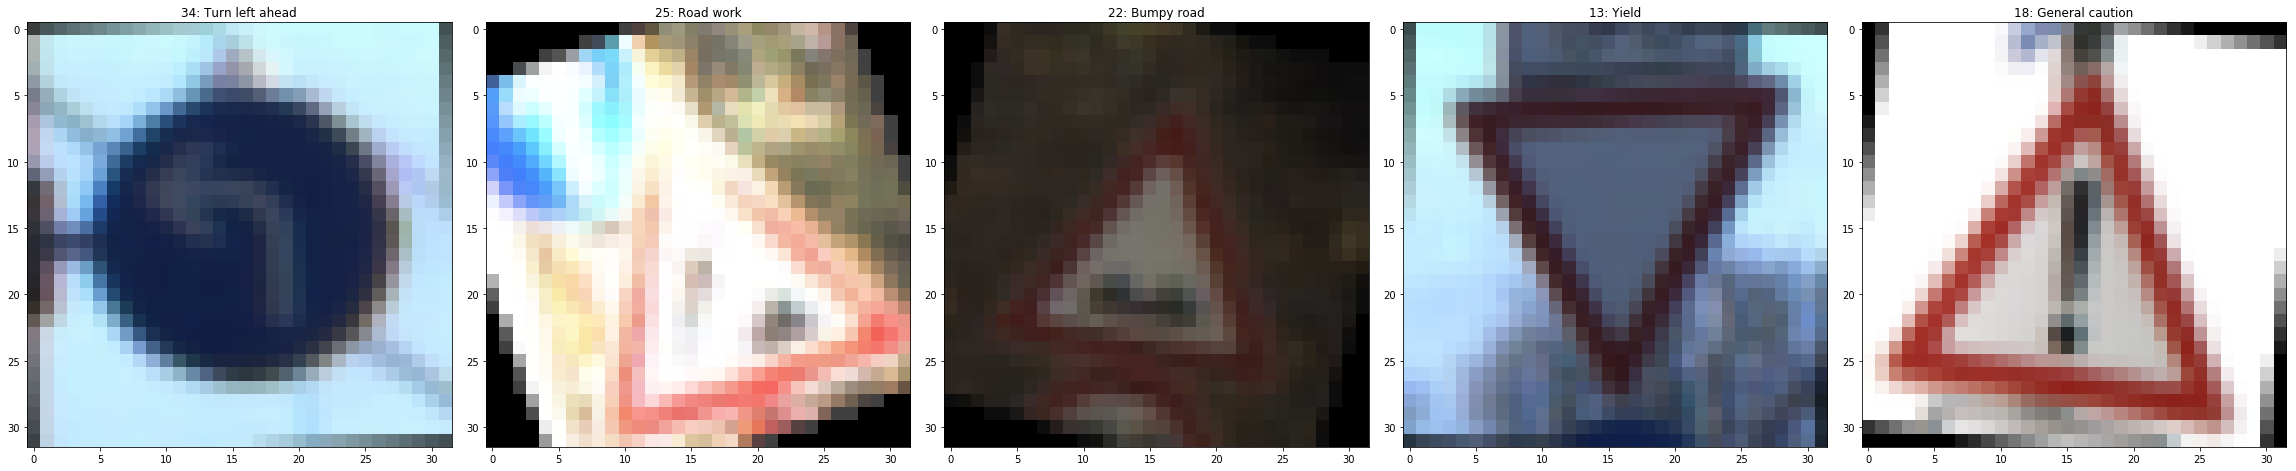

In [19]:
display_X_y_images(X_train, y_train, signnames_pd, 0, 5, use_gray=True, 
                   apply_fnc=apply_random_rotate)

### Shift

The image shift is +/-5 up or down and left or right.

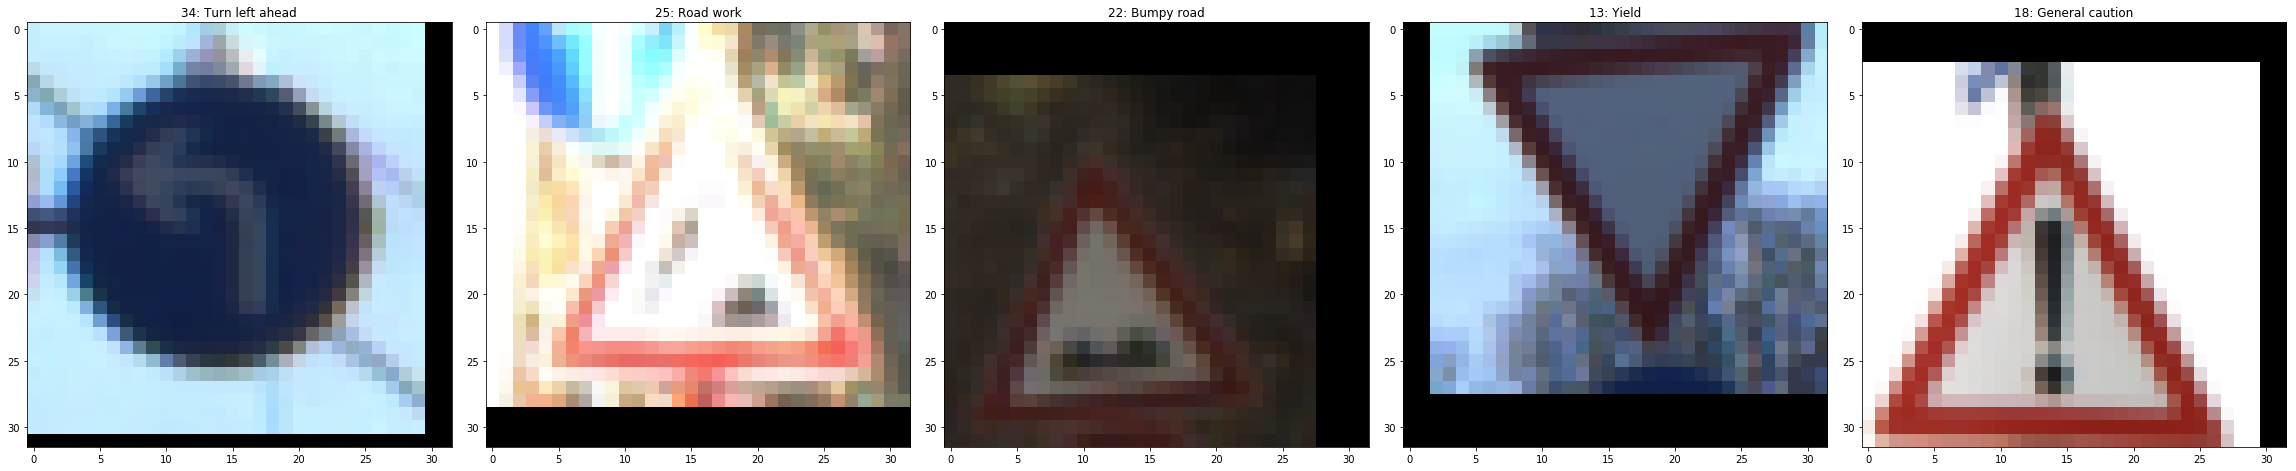

In [20]:
display_X_y_images(X_train, y_train, signnames_pd, 0, 5, use_gray=True, 
                   apply_fnc=apply_random_shift)

### Shear

The image shear is from -0.2 to 0.2 radians.

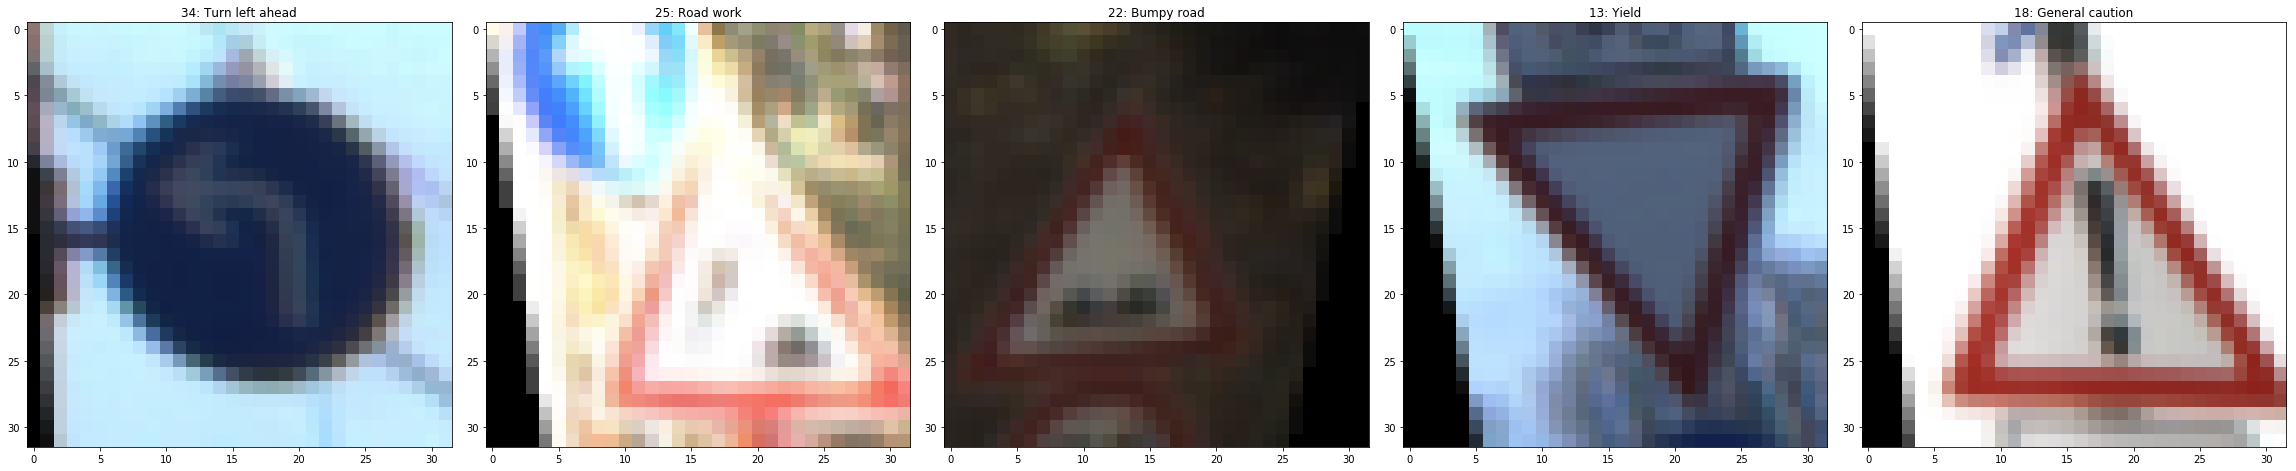

In [21]:
display_X_y_images(X_train, y_train, signnames_pd, 0, 5, use_gray=True, 
                   apply_fnc=apply_random_shear)

In [22]:
def balance_images(X, y, min_angle=-12.5, max_angle=12.5, 
                   min_x_shift=-3, max_x_shift=3, min_y_shift=-5, max_y_shift=5, 
                   min_shear=-0.2, max_shear=0.2):
    #print("###1. balance_images - min_x_shift, max_x_shift, min_y_shift, max_y_shift", 
    #                  min_x_shift, max_x_shift, min_y_shift, max_y_shift)
    label_cnts = Counter(y_train)
    
    max_cnt = max([y for _, y in label_cnts.items()])
    
    image_dict = {}
    for i in range(X.shape[0]):
        curr_image = X[i]
        curr_y = y[i]
        
        if curr_y in image_dict:
            image_dict[curr_y].append(curr_image)
        else:
            image_dict[curr_y] = [curr_image]
            
    for label, image_arr in image_dict.items():
        initial_cnt = len(image_arr)
        for i in range(max_cnt-initial_cnt):
            idx = randrange(0, initial_cnt)
            curr_image = image_arr[idx]
                
            rnd = randrange(0,3)    
            if rnd == 0:
                alt_image = apply_random_rotate(curr_image, min_angle, max_angle)  
            elif rnd == 1:
                alt_image = apply_random_shift(curr_image, min_x_shift, max_x_shift, 
                                               min_y_shift, max_y_shift)                 
            else:
                alt_image = apply_random_shear(curr_image, min_shear, max_shear)
                
            image_dict[label].append(alt_image)
            
    balanced_label_arr = []
    balanced_image_arr = []
    for label, image_arr in image_dict.items():
        balanced_label_arr += [label] * len(image_arr)
        balanced_image_arr += image_arr
        
    balanced_labels = np.array(balanced_label_arr).reshape((-1))
    balanced_images = np.stack(balanced_image_arr)
    
    return balanced_images, balanced_labels

In [23]:
X_train_balanced, y_train_balanced = balance_images(X_train, y_train, 
                                                    min_angle=-20.0, max_angle=20.0, 
                                                    min_x_shift=-5, max_x_shift=5, 
                                                    min_y_shift=-5, max_y_shift=5, 
                                                    min_shear=-0.2, max_shear=0.2)

X_train_balanced, y_train_balanced = shuffle_X_y(X_train_balanced, y_train_balanced)

#### Grayscale images with Histogram Equalization

In [24]:
def apply_histogram_equalization(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    equalized_image = exposure.equalize_adapthist(gray_image)
    
    return (255.0*equalized_image).astype(np.uint8)

Here is a version of the same images in grayscale.  Histogram Equalization has been 
applied to sharpen the images.  

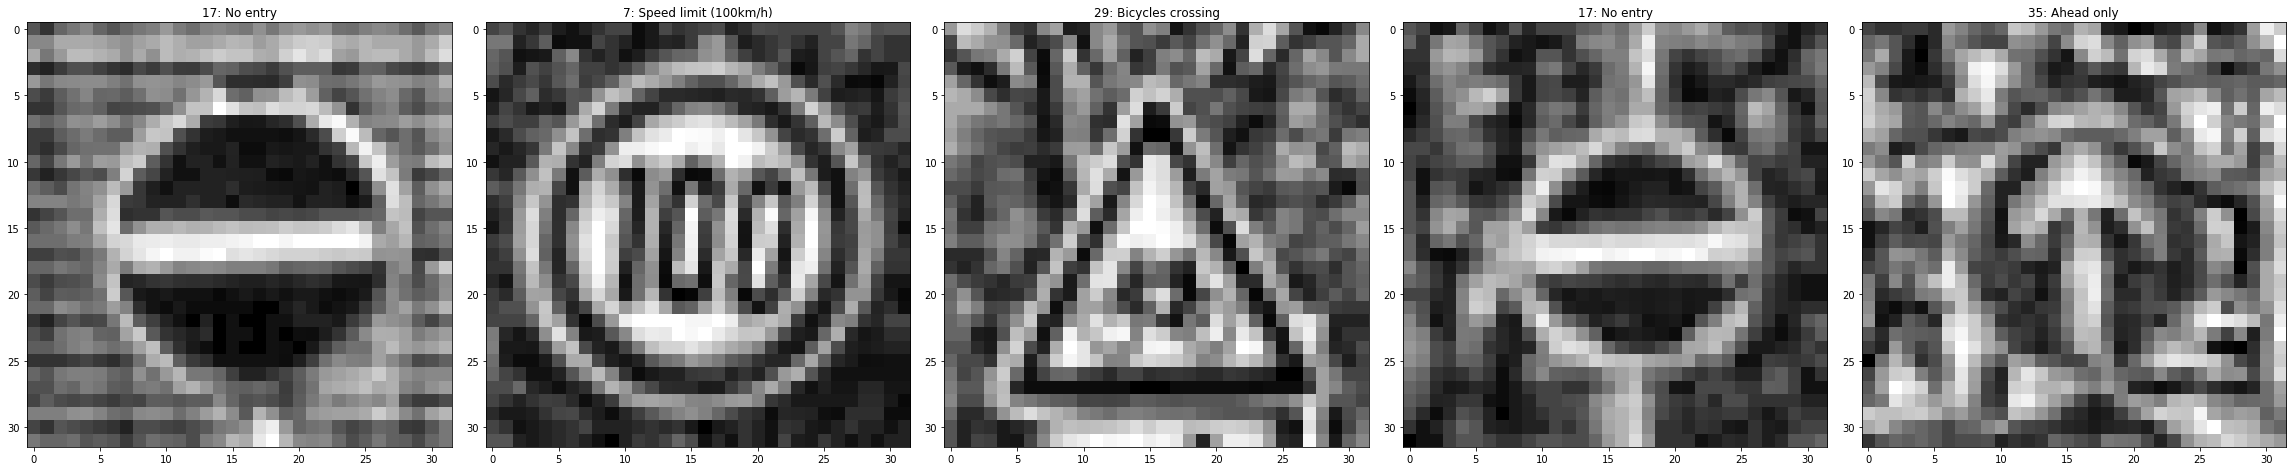

In [25]:
display_X_y_images(X_train, y_train, signnames_pd, start_idx=20, end_idx=25, 
                   use_gray=True, apply_fnc=apply_histogram_equalization)

In [26]:
def get_color_layers(image):
    temp_image = image.copy()

    layers_arr = [temp_image[:,:,i] for i in range(temp_image.shape[2])]

    he_image = apply_histogram_equalization(temp_image)
    layers_arr.append(he_image)
    
    color_layers = np.stack(layers_arr, axis=2)
    
    assert color_layers.shape[2] == 4, color_layers.shape
    
    return color_layers

In [27]:
def preprocess_images(images):
    #temp_images = images.copy()
    
    color_layers_images = np.stack([get_color_layers(images[i]) 
                                    for i in tqdm(range(images.shape[0]))]).astype(np.float32)
            
    assert color_layers_images.shape[0] == images.shape[0], (color_layers_images.shape[0],
                                                            images.shape[0])
        
    # normalize data
    for i in tqdm(range(color_layers_images.shape[3])):
        curr_layer = color_layers_images[:, :, :, i]
        min_val = curr_layer.min()
        max_val = curr_layer.max()
        mean_val = curr_layer.mean()
            
        val_range = max_val - min_val + 1.0**-9
        
        #masked_images[:, :, :, i] = 0.5*(curr_layer-mean_val)/val_range    
        color_layers_images[:, :, :, i] = (curr_layer-mean_val)/val_range

    return color_layers_images

In [28]:
import multiprocessing as mp

class MP(object):
    def __init__(self, worker, input_splitter, output_joiner, num_of_workers=3):
        self.worker = worker
        self.input_splitter = input_splitter
        self.output_joiner = output_joiner
        self.num_of_workers = num_of_workers
        
    def split_input(self, input, n):
        return [{'idx':i, 'data':input_part} for i, input_part in enumerate(self.input_splitter(input, n))]
    
    def run(self, input):
        pool = mp.Pool()
        
        split_input = self.split_input(input, self.num_of_workers)
    
        output = pool.map(self.worker, split_input)
        
        return self.output_joiner(output, self.num_of_workers)

In [29]:
def preprocess_images_worker(val):
    idx, images = val['idx'], val['data']
  
    result = preprocess_images(images)
        
    return {'idx': idx, 'result': result}
    
def input_splitter(images, n):
    return [x for x in np.array_split(images, n)]
        
def output_joiner(output, n):
    output_dict = {x['idx']: x['result'] for x in output}
        
    output_arr = [output_dict[i] for i in range(n)]
        
    return np.concatenate(output_arr, axis=0)

def preprocess_images_mt(images, num_of_workers):     
    preprocess_images_mp = MP(preprocess_images_worker, input_splitter, output_joiner, num_of_workers)
    return preprocess_images_mp.run(images)

In [30]:
def preprocess_X_y(X, y, data_dir, type_name, n=8):
    X_preprocessed_file = '%s/X_%s_preprocessed' % (data_dir, type_name)
    y_preprocessed_file = '%s/y_%s_preprocessed' % (data_dir, type_name)
    if os.path.exists('%s.npy' % X_preprocessed_file) \
        and os.path.exists('%s.npy' % y_preprocessed_file):
        X_preprocessed = np.load('%s.npy' % X_preprocessed_file)
        y_preprocessed = np.load('%s.npy' % y_preprocessed_file)
    else:
        X_preprocessed = preprocess_images_mt(X, n)
        y_preprocessed = y
        np.save(X_preprocessed_file, X_preprocessed)
        np.save(y_preprocessed_file, y_preprocessed)

    return X_preprocessed, y_preprocessed

In [31]:
X_train_preprocessed, y_train_preprocessed = preprocess_X_y(X_train, y_train, 
                                                             data_dir, 'train',
                                                             n=8)

In [32]:
X_valid_preprocessed,  y_valid_preprocessed = preprocess_X_y(X_valid, y_valid, 
                                                             data_dir, 'valid',
                                                             n=8)

In [33]:
X_test_preprocessed,  y_test_preprocessed = preprocess_X_y(X_test, y_test, 
                                                           data_dir, 'test',
                                                             n=8)

### Model Architecture

In [34]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [35]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

In [36]:
def leaky_relu(x, alpha, name):
    return tf.maximum(alpha * x, x, name) 

def conv_layer(x, num_input_channels, num_output_channels, 
               mu, sigma, window=(5,5)):
    window_x,window_y = window
    conv_W = tf.Variable(tf.truncated_normal(shape=(window_x, window_y, 
                                                    num_input_channels, num_output_channels), 
                                                     mean = mu, stddev = sigma))
    conv_b = tf.Variable(tf.zeros(num_output_channels))
    return tf.nn.conv2d(x, conv_W, strides=[1, 1, 1, 1], padding='SAME') + conv_b, conv_W

def fully_connected(x, shape_in, shape_out, mu = 0, sigma = 0.1):
    fc_W  = tf.Variable(tf.truncated_normal(shape=(shape_in, shape_out), 
                                            mean = mu, stddev = sigma))
    fc_b  = tf.Variable(tf.zeros(shape_out))
    return tf.matmul(x, fc_W) + fc_b, fc_W

In [37]:
def model(x, channel_depth, mu = 0, sigma = 1e-2, alpha=0.05): 
    ### Layer 1: Convolutional. Input = 32x32x10. Output = 32x32x16.
    conv1, conv1_W = conv_layer(x, channel_depth, 16, mu, sigma)
    print(conv1.get_shape())

    # Leaky ReLU
    conv1_activaton = leaky_relu(conv1, alpha, 'conv1_activaton')    

    # Pooling. Input = 32x32x16. Output = 16x16x16.
    conv1 = tf.nn.max_pool(conv1_activaton, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    print(conv1.get_shape())

    ### Layer 2: Convolutional. Output = 16x16x32.
    conv2, conv2_W = conv_layer(conv1, 16, 32, mu, sigma)
    print(conv2.get_shape())

    # Leaky ReLU
    conv2_activaton = leaky_relu(conv2, alpha, 'conv2_activaton')  

    # Pooling. Input = 16x16x32. Output = 8x8x32.
    conv2 = tf.nn.max_pool(conv2_activaton, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    print(conv2.get_shape())

    ### Layer 3: Convolutional. Output = 8x8x64.
    conv3, conv3_W = conv_layer(conv2, 32, 64, mu, sigma)
    print(conv3.get_shape())

    # Leaky ReLU
    conv3_activaton = leaky_relu(conv3, alpha, 'conv3_activaton')  

    # Pooling. Input = 8x8x64. Output = 4x4x64.
    conv3 = tf.nn.max_pool(conv3_activaton, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') 
    print(conv3.get_shape())

    # Flatten. Input = 4x4x64. Output = 1024.
    fc0   = flatten(conv3)

    ### Layer 3: Fully Connected. Input = 1024. Output = 512.
    fc1, fc1_W = fully_connected(fc0, 1024, 512, mu, sigma)

    # Leaky ReLU
    fc1 = leaky_relu(fc1, alpha, 'fc1_activation')  
    
    # dropout
    keep_prob = tf.placeholder(tf.float32)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    ### Layer 4: Fully Connected. Input = 512. Output = 256.
    fc2, fc2_W = fully_connected(fc1, 512, 256, mu, sigma)

    # Leaky ReLU
    fc2 = leaky_relu(fc2, alpha, 'fc2_activation')   
    
    # dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)    

    # Layer 5: Fully Connected. Input = 256. Output = 43.
    logits, fc3_W = fully_connected(fc2, 256, 43, mu, sigma)

    return (logits, keep_prob, [conv1_W, conv2_W, conv3_W, fc1_W, fc2_W, fc3_W],
            [conv1_activaton, conv2_activaton, conv3_activaton])

In [38]:
channel_depth = 4
x = tf.placeholder(tf.float32, (None, 32, 32, channel_depth))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [39]:
rate = 1e-3       # learning rate
alpha = 1e-05     # slope for negative input values for leaky ReLU's
sigma = 1e-2      # std for initializing random weights
beta = 1e-4       # multiplier for L2 regularization

logits, keep_prob, weights, activations = model(x, channel_depth, sigma=sigma, alpha=alpha)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

loss_operation = tf.reduce_mean(cross_entropy)

# Loss function using L2 Regularization
regularizer = None
for weight in weights:
    if regularizer is None:
        regularizer = tf.nn.l2_loss(weight)
    else:
        regularizer = regularizer + tf.nn.l2_loss(weight)
loss_operation = tf.reduce_mean(loss_operation + beta * regularizer)

optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

(?, 32, 32, 16)
(?, 16, 16, 16)
(?, 16, 16, 32)
(?, 8, 8, 32)
(?, 8, 8, 64)
(?, 4, 4, 64)


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [40]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

In [41]:
EPOCHS = 100
BATCH_SIZE = 128

In [42]:
logits_argmax = tf.argmax(logits, 1, name='logits_argmax')
one_hot_y_argmax = tf.argmax(one_hot_y, 1, name='one_hot_y_argmax')
correct_prediction = tf.equal(logits_argmax, one_hot_y_argmax, name='correct_prediction')
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [43]:
def train_model(epochs, batch_size, X_train_preprocessed, y_train, 
                X_valid_preprocessed, y_valid, model_name, keep_prob_val = 0.5,
                max_to_keep=0):
    saver = tf.train.Saver(max_to_keep=max_to_keep)
    model_dir = '%s/models/%s' % (data_dir, model_name)
    os.makedirs(model_dir, exist_ok=True)
    
    validation_accuracy_arr = []
    
    best_validation_accuracy_epoch = 0
    best_validation_accuracy = 0.0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train_preprocessed)
    
        print("Training...")
        print()
        for i in range(epochs):
            X_train_preprocessed, y_train = shuffle_X_y(X_train_preprocessed, y_train)
        
            for offset in range(0, num_examples, batch_size):
                end = offset + BATCH_SIZE
                batch_x, batch_y = (X_train_preprocessed[offset:end], 
                                    y_train[offset:end])
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, 
                                                        keep_prob: keep_prob_val})
        
            validation_accuracy = evaluate(X_valid_preprocessed, y_valid)
            validation_accuracy_arr.append(validation_accuracy)
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
            if best_validation_accuracy < validation_accuracy:
                best_validation_accuracy = validation_accuracy
                best_validation_accuracy_epoch = i+1
                saver.save(sess, '%s/%s' % (model_dir, model_name))
                print("Model saved")
            
            print()
            
    print("Best model - epoch: %d, best validation accuracy: %.3f" % 
          (best_validation_accuracy_epoch, best_validation_accuracy))
    
    return validation_accuracy_arr

In [44]:
def display_test_accuracy(X_test_preprocessed, y_test, model_name):
    model_dir = '%s/models/%s' % (data_dir, model_name)
    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, tf.train.latest_checkpoint(model_dir))

        test_accuracy = evaluate(X_test_preprocessed, y_test)
        print("Test Accuracy = {:.3f}".format(test_accuracy))

In [45]:
def predict_model(X, model_name, batch_size):
    if X.shape[0] < batch_size:
        batch_size = X.shape[0]
        
    model_dir = '%s/models/%s' % (data_dir, model_name)
    saver = tf.train.Saver()
    
    logits_argmax_arr = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())  
        saver.restore(sess, tf.train.latest_checkpoint(model_dir))
        
        start_idx = 0
        end_idx = 0
        while start_idx < X.shape[0]:
            end_idx += batch_size
            end_idx = min(end_idx, X.shape[0])
            logits_argmax_arr.append(sess.run(logits_argmax, 
                                              feed_dict={x: X[start_idx:end_idx], 
                                                         keep_prob: 1.0}))
            start_idx += batch_size
        
    result = np.concatenate(logits_argmax_arr, axis=0)
    
    assert result.shape[0] == X.shape[0]
    
    return result

In [46]:
def predict_ensemble_models(X, model_prefix, n, batch_size):
    results = []
    for i in tqdm(range(n)):
        model_name = '%s_%d' % (model_prefix, i)
        
        results.append(predict_model(X, model_name, batch_size=batch_size))
    
    return results

### Single model

In [119]:
model_name = 'single_model' 
print("###%s" % model_name)
validation_accuracy_arr = train_model(EPOCHS, BATCH_SIZE, 
                                      X_train_preprocessed, y_train_preprocessed, 
                                      X_valid_preprocessed, y_valid, 
                                      model_name, keep_prob_val = 0.5, max_to_keep=0)    
    
display_test_accuracy(X_test_preprocessed, y_test, model_name)

###single_model
Training...

EPOCH 1 ...
Validation Accuracy = 0.127
INFO:tensorflow:./data/models/single_model/single_model is not in all_model_checkpoint_paths. Manually adding it.
Model saved

EPOCH 2 ...
Validation Accuracy = 0.465
INFO:tensorflow:./data/models/single_model/single_model is not in all_model_checkpoint_paths. Manually adding it.
Model saved

EPOCH 3 ...
Validation Accuracy = 0.728
INFO:tensorflow:./data/models/single_model/single_model is not in all_model_checkpoint_paths. Manually adding it.
Model saved

EPOCH 4 ...
Validation Accuracy = 0.829
INFO:tensorflow:./data/models/single_model/single_model is not in all_model_checkpoint_paths. Manually adding it.
Model saved

EPOCH 5 ...
Validation Accuracy = 0.897
INFO:tensorflow:./data/models/single_model/single_model is not in all_model_checkpoint_paths. Manually adding it.
Model saved

EPOCH 6 ...
Validation Accuracy = 0.910
INFO:tensorflow:./data/models/single_model/single_model is not in all_model_checkpoint_paths. Ma

In [122]:
def get_individual_accuracy(y, y_hat):
    image_cnt = y.shape[0]

    correct_cnt = 0
    
    for i in range(image_cnt):
        if y[i] == y_hat[i]:
            correct_cnt += 1
        
    return float(correct_cnt)/image_cnt    

In [123]:
def display_single_accuracy_barplot(train_accuracy, valid_accuracy, test_accuracy, title):
    
    n_groups = 3

    # create plot
    fig, ax = plt.subplots(figsize=(5, 5))
    index = np.arange(n_groups)
    bar_width = 0.25
    opacity = 0.8
 
    rects1 = plt.bar(index, [train_accuracy, valid_accuracy, test_accuracy], bar_width,
                     alpha=opacity,
                     color=['#B3B3B3', '#1F1A4F', '#C82027'],
                     label='Train')
 
    plt.xlabel('Models').set_fontsize(12)
    plt.ylabel('Accuracies').set_fontsize(12)
    plt.title(title).set_fontsize(18)
    plt.xticks(index, ['train', 'valid', 'test'])
    plt.legend(fontsize='medium')

    plt.show()

#### Accuracy

In [124]:
# Train Accuracy
y_train_hat = predict_model(X_train_preprocessed, 'single_model', batch_size=BATCH_SIZE)

train_accuracy = get_individual_accuracy(y_train_preprocessed, y_train_hat)

# Validation Accuracy
y_valid_hat = predict_model(X_valid_preprocessed, 'single_model', batch_size=BATCH_SIZE)

valid_accuracy = get_individual_accuracy(y_valid_preprocessed, y_valid_hat)

# Test Accuracy
y_test_hat = predict_model(X_test_preprocessed, 'single_model', batch_size=BATCH_SIZE)

test_accuracy = get_individual_accuracy(y_test_preprocessed, y_test_hat)

In [125]:
print('Type\tAccuracy')
print('================')
print('train\t%.3f' % train_accuracy)
print('valid\t%.3f' % valid_accuracy)
print('test\t%.3f' % test_accuracy)

Type	Accuracy
train	1.000
valid	0.975
test	0.959


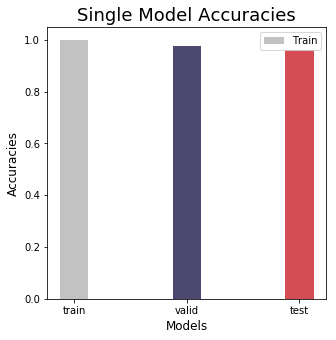

In [126]:
display_single_accuracy_barplot(train_accuracy, valid_accuracy, test_accuracy, 
                               'Single Model Accuracies')

In [127]:
def pad_str(text_str, str_len, pad_char=' '):
    while len(text_str) < str_len:
        text_str += pad_char 
        
    return text_str

In [128]:
def display_incorrect_labels(y, y_hat):
    bad_labels = []
    for i in range(y.shape[0]):
        if y[i] != y_hat[i]:
            bad_labels.append(y[i])
        
    bad_label_cnt_dict = Counter(bad_labels)

    print("#     Label                                              Count")
    print("==============================================================")
    for label, count in bad_label_cnt_dict.most_common(10):
        
        row_str = "%d" % label
        row_str = pad_str(row_str, 6)
            
        row_str += signname_val_to_name(signnames_pd, label)
        
        row_str = pad_str(row_str, 60)      
        
        row_str += "%d" % count
        
        print(row_str)

### Incorrect Labels

#### Validation

In [129]:
display_incorrect_labels(y_valid_preprocessed, y_valid_hat)

#     Label                                              Count
16    Vehicles over 3.5 metric tons prohibited              30
24    Road narrows on the right                             21
21    Double curve                                          15
20    Dangerous curve to the right                          9
18    General caution                                       6
2     Speed limit (50km/h)                                  4
23    Slippery road                                         4
9     No passing                                            3
42    End of no passing by vehicles over 3.5 metric tons    3
41    End of no passing                                     3


#### Test

In [130]:
display_incorrect_labels(y_test_preprocessed, y_test_hat)

#     Label                                              Count
18    General caution                                       65
30    Beware of ice/snow                                    51
11    Right-of-way at the next intersection                 31
21    Double curve                                          30
27    Pedestrians                                           28
8     Speed limit (120km/h)                                 27
24    Road narrows on the right                             24
3     Speed limit (60km/h)                                  22
5     Speed limit (80km/h)                                  22
17    No entry                                              22


### Ensemble model

In [ ]:
n = 10
batch_perc = 0.9
models_validation_accuracy_arr = []

for i in range(n):
    sample_len = int(batch_perc*X_train_preprocessed.shape[0])
    X_train_preprocessed, y_train_preprocessed = shuffle_X_y(X_train_preprocessed, y_train_preprocessed)      
    _X_train_preprocessed = X_train_preprocessed[:sample_len]
    _y_train_preprocessed = y_train_preprocessed[:sample_len]
    
    model_name = 'model_%d' % i
    print("###%s" % model_name)
    validation_accuracy_arr = train_model(EPOCHS, BATCH_SIZE, 
                                          _X_train_preprocessed, _y_train_preprocessed, 
                                          X_valid_preprocessed, y_valid, 
                                          model_name, keep_prob_val = 0.5, max_to_keep=0) 
    models_validation_accuracy_arr.append(validation_accuracy_arr)
    
    display_test_accuracy(X_test_preprocessed, y_test, model_name)

#### Individual Accuracies

In [70]:
def get_individual_accuracies(y, y_hat_arr):
    accuracy_arr = []
    image_cnt = y.shape[0]

    for j in tqdm(range(len(y_hat_arr))):
        correct_cnt = 0

        curr_y_hat = y_hat_arr[j]
        assert curr_y_hat.shape[0] == image_cnt, "%d, %d" % (curr_y_hat.shape[0], image_cnt)
        
        for i in range(image_cnt):
            if y[i] == curr_y_hat[i]:
                correct_cnt += 1
        
        accuracy = float(correct_cnt)/image_cnt
        accuracy_arr.append(accuracy)
        
    return accuracy_arr

##### Train Accuracy

In [71]:
n = 10

In [72]:
y_ensemble_train_hat_arr = predict_ensemble_models(X_train_preprocessed, 'model', 
                                                   n, batch_size=BATCH_SIZE)
ensemble_train_accuracy_arr = get_individual_accuracies(y_train_preprocessed, 
                                                        y_ensemble_train_hat_arr)

print("Model\tAccuracy")
print("================")
for i, ensemble_train_accuracy in enumerate(ensemble_train_accuracy_arr):
    print("%d\t %.3f" % (i, ensemble_train_accuracy))

100%|██████████| 10/10 [00:02<00:00,  3.84it/s]

Model	Accuracy
0	 0.033
1	 0.033
2	 0.045
3	 0.006
4	 0.041
5	 0.008
6	 0.017
7	 0.016
8	 0.012
9	 0.020


##### Validation Accuracy

In [73]:
y_ensemble_valid_hat_arr = predict_ensemble_models(X_valid_preprocessed, 'model', 
                                                   n, batch_size=BATCH_SIZE)

ensemble_valid_accuracy_arr = get_individual_accuracies(y_valid_preprocessed, 
                                                        y_ensemble_valid_hat_arr)

print("Model\tAccuracy")
print("================")
for i, ensemble_valid_accuracy in enumerate(ensemble_valid_accuracy_arr):
    print("%d\t%.3f" % (i, ensemble_valid_accuracy))

 30%|███       | 3/10 [00:53<02:04, 17.80s/it]

KeyboardInterrupt: 

##### Test Accuracy

In [ ]:
y_ensemble_test_hat_arr = predict_ensemble_models(X_test_preprocessed, 'model', 
                                                   n, batch_size=BATCH_SIZE)
ensemble_test_accuracy_arr = get_individual_accuracies(y_test_preprocessed, y_ensemble_test_hat_arr)

print("Model\tAccuracy")
print("================")
for i, ensemble_test_accuracy in enumerate(ensemble_test_accuracy_arr):
    print("%d\t %.3f" % (i, ensemble_test_accuracy))

In [ ]:
# data to plot
n_groups = 10

# create plot
fig, ax = plt.subplots(figsize=(20, 10))
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8
 
rects1 = plt.bar(index, ensemble_train_accuracy_arr, bar_width,
                 alpha=opacity,
                 color='#B3B3B3',
                 label='Train')
 
rects2 = plt.bar(index + bar_width, ensemble_valid_accuracy_arr, bar_width,
                 alpha=opacity,
                 color='#1F1A4F',
                 label='Validation')

rects3 = plt.bar(index + 2*bar_width, ensemble_test_accuracy_arr, bar_width,
                 alpha=opacity,
                 color='#C82027',
                 label='Test')
 
plt.xlabel('Models').set_fontsize(24)
plt.ylabel('Accuracies').set_fontsize(24)
plt.title('Individual Model Accuracies').set_fontsize(32)
plt.xticks(index + bar_width, range(n_groups))
plt.legend(fontsize='x-large')
 
plt.tight_layout()
plt.show()

#### Ensembled Accuracies

In [ ]:
def predict_model_softmax_logits(X, model_name, batch_size):
    if X.shape[0] < batch_size:
        batch_size = X.shape[0]
        
    model_dir = '%s/models/%s' % (data_dir, model_name)
    saver = tf.train.Saver()
    
    softmax_logit_vals_arr = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())  
        saver.restore(sess, tf.train.latest_checkpoint(model_dir))
        
        softmax_logits = tf.nn.softmax(logits)
        
        start_idx = 0
        end_idx = 0
        while start_idx < X.shape[0]:
            end_idx += batch_size
            end_idx = min(end_idx, X.shape[0])
            softmax_logit_vals = sess.run(softmax_logits, feed_dict={x: X[start_idx:end_idx], 
                                                                     keep_prob: 1.0})
            softmax_logit_vals_arr.append(softmax_logit_vals)
            
            start_idx += batch_size
        
    final_softmax_logit_vals = np.concatenate(softmax_logit_vals_arr, axis=0)
    
    assert final_softmax_logit_vals.shape[0] == X.shape[0]
    assert final_softmax_logit_vals.shape[1] == 43
    
    return final_softmax_logit_vals

In [ ]:
def get_best_softmax_logits(softmax_logits):
    softmax_logits_pd = pd.DataFrame(data={'softmax_logit': softmax_logits}, index=range(43))
    
    softmax_logits_pd.sort_values(by='softmax_logit', ascending=False, inplace=True)
    
    return softmax_logits_pd.index[0]

In [ ]:
def ensemble_results(y_hat_arr):
    er_arr = []
    
    for i in range(y_hat_arr[0].shape[0]):
        curr_results = []
        for j in range(len(y_hat_arr)):
            curr_results.append(y_hat_arr[j][i])
            
        mode_result = Counter(curr_results).most_common(1)
        mode_val = mode_result[0][0]
        er_arr.append(mode_val)     
    
    er = np.array(er_arr).reshape((-1))  
    assert er.shape[0] == y_hat_arr[0].shape[0]     
                                               
    return er     

In [ ]:
def predict_msl_ensemble_model(X, model_prefix, n, batch_size):
    softmax_logits_arr = [predict_model_softmax_logits(X, '%s_%d' % (model_prefix, i), 
                                                       batch_size) for i in tqdm(range(n))]
    softmax_logits_np = np.stack(softmax_logits_arr)
    
    assert softmax_logits_np.shape[0] == n
    
    mean_softmax_logits_np = np.mean(softmax_logits_np, axis=0)
    
    assert mean_softmax_logits_np.shape[0] == X.shape[0]
    assert mean_softmax_logits_np.shape[1] == 43
    
    best_softmax_logits_arr = []
    for i in tqdm(range(mean_softmax_logits_np.shape[0])):
        curr_mean_softmax_logits_np = mean_softmax_logits_np[i]
        
        best_softmax_logits_arr.append(get_best_softmax_logits(curr_mean_softmax_logits_np))
        
    return np.array(best_softmax_logits_arr)

In [ ]:
def display_accuracy_table(train_accuracy, valid_accuracy, test_accuracy):
    print("Type\tAccuracy")
    print("================")
    print("train\t%.3f" % train_accuracy)
    print("valid\t%.3f" % valid_accuracy)
    print("test\t%.3f" % test_accuracy)

##### Ensemble Methods

Two different ensemble methods were used: 
1. Voting
    * The predicted label from each model counts as one vote.
    * The label with the most votes is the predicted label.
2. Mean Softmax Logits
    * For each model, all of the softmax logits for an image were calculated.
    * From the softmax logits for all models, the means of each softmax logit were taken.
    * The logit with the max mean softmax is the predicted label.

###### Voting

In [ ]:
# Train accuracy
y_ensembled_train_hat = ensemble_results(y_ensemble_train_hat_arr)
train_accuracy = get_individual_accuracy(y_train_preprocessed, y_ensembled_train_hat)

# Validation Accuracy
y_ensembled_valid_hat = ensemble_results(y_ensemble_valid_hat_arr)
valid_accuracy = get_individual_accuracy(y_valid_preprocessed, y_ensembled_valid_hat)

# Test Accuracy
y_ensembled_test_hat = ensemble_results(y_ensemble_test_hat_arr)
test_accuracy = get_individual_accuracy(y_test_preprocessed, y_ensembled_test_hat)

In [ ]:
display_accuracy_table(train_accuracy, valid_accuracy, test_accuracy)

In [ ]:
display_single_accuracy_barplot(train_accuracy, valid_accuracy, test_accuracy,
                               'Voting Ensemble Model Accuracies')

###### Mean Softmax Logits

In [ ]:
# Train accuracy
y_ensembled_train_hat = predict_msl_ensemble_model(X_train_preprocessed, 'model', 10, BATCH_SIZE)
train_accuracy = get_individual_accuracy(y_train_preprocessed, y_ensembled_train_hat)

# Validation Accuracy
y_ensembled_valid_hat = predict_msl_ensemble_model(X_valid_preprocessed, 'model', 10, BATCH_SIZE)
valid_accuracy = get_individual_accuracy(y_valid_preprocessed, y_ensembled_valid_hat)

# Test Accuracy
y_ensembled_test_hat = predict_msl_ensemble_model(X_test_preprocessed, 'model', 10, BATCH_SIZE)
test_accuracy = get_individual_accuracy(y_test_preprocessed, y_ensembled_test_hat)

In [ ]:
display_accuracy_table(train_accuracy, valid_accuracy, test_accuracy)

In [ ]:
display_single_accuracy_barplot(train_accuracy, valid_accuracy, test_accuracy,
                               'Mean Softmax Logits Model Accuracies')

For the most part, the accuracy of both models are the same. Both have the same test accuracy of 99.0%  The Mean Softmax Logits model has a slightly slower a validation accuracy of 98.9%.

### Incorrect Labels

#### Validation 

In [ ]:
display_incorrect_labels(y_valid_preprocessed, y_ensembled_valid_hat)

#### Test

In [ ]:
display_incorrect_labels(y_test_preprocessed, y_ensembled_test_hat)

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

In [ ]:
def read_images(img_dir, csv_file, csv_delimiter=';'):
    meta_pd = pd.read_csv('%s/%s' % (img_dir, csv_file), delimiter=csv_delimiter)
    
    image_arr = []
    
    for index, row in meta_pd.iterrows():
        filename = '%s/%s' % (img_dir, row['Filename'])
        
        pil_image = Image.open(filename)
        image = np.array(pil_image)
        image_arr.append(image)
        
    return image_arr, meta_pd

In [ ]:
def crop_resize_images(image_arr, meta_pd, resize_dim):
    cropped_resized_images = []
    
    for index, row in meta_pd.iterrows():
        image = image_arr[index]
        assert image.shape[0] == row['Height'], "image.shape[0] = %d, row['Height'] = %d" % (image.shape[0], row['Height'])
        assert image.shape[1] == row['Width'], "image.shape[1] = %d, row['Width'] = %d" % (image.shape[1], row['Width'])
        
        cropped_image = image[row['Roi.Y1']:row['Roi.Y2'], row['Roi.X1']:row['Roi.X2']]   
        resized_image = resize(cropped_image, resize_dim, mode='constant')
        
        cropped_resized_images.append(resized_image)
        
    return np.stack(cropped_resized_images)

In [ ]:
def make_image_dataset(main_img_dir, resize_dim=(32, 32, 3), csv_delimiter=';', has_subdirs=True):
    feature_arr = []
    label_arr = []
    sizes = []
    coords = []
    
    if has_subdirs:
        for curr_dir in tqdm([x for x in os.listdir(main_img_dir) if not x.startswith('.') and x != 'annotations']):
            csv_file = [x for x in os.listdir('%s/%s' % (main_img_dir, curr_dir)) if x.endswith('.csv')][0]
            image_arr, meta_pd = read_images('%s/%s' % (main_img_dir, curr_dir), csv_file, csv_delimiter=csv_delimiter)
                                          
            cr_images = crop_resize_images(image_arr, meta_pd, resize_dim)
            feature_arr.append(cr_images)
        
            label_arr += [int(curr_dir)] * cr_images.shape[0]
            sizes += [(row['Width'], row['Height']) for _, row in meta_pd.iterrows()]
            coords += [(row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2']) for _, row in meta_pd.iterrows()]
    else:
        csv_file = [x for x in os.listdir(main_img_dir) if x.endswith('.csv')][0]
        image_arr, meta_pd = read_images(main_img_dir, csv_file, csv_delimiter=csv_delimiter)
                                          
        cr_images = crop_resize_images(image_arr, meta_pd, resize_dim)
        feature_arr.append(cr_images)
        
        # since it's not in a subdir, set it to an unknown label
        label_arr += meta_pd['ClassId'].tolist()
        sizes += [(row['Width'], row['Height']) for _, row in meta_pd.iterrows()]
        coords += [(row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2']) for _, row in meta_pd.iterrows()]        
          
    features = (255.0 * np.concatenate(feature_arr, axis=0)).astype(np.uint8)
    labels = np.array(label_arr)
    
    assert features.shape[0] == labels.shape[0]
    assert labels.shape[0] == len(sizes)
    assert len(sizes) == len(coords)
    
    return {
        'features': features,
        'labels': labels,
        'sizes': sizes,
        'coords': coords
    }                                                                    

In [ ]:
extra_images_dir = 'extra'
extra_image_dataset = make_image_dataset(extra_images_dir, resize_dim=(32, 32, 3), csv_delimiter="\t", has_subdirs=False)

In [ ]:
X_extra, y_extra = extra_image_dataset['features'], extra_image_dataset['labels']

In [ ]:
display_X_y_images(X_extra, y_extra, signnames_pd, 0, 10)

In [ ]:
X_extra_preprocessed = preprocess_images(X_extra)
y_extra_preprocessed = y_extra

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

In [ ]:
def display_predicted_labels(y, y_hat):
    correct_cnt = 0 
    
    header_str = pad_str("label", 40)
    header_str += "predicted label"
    print(header_str)
    
    print("==============================================================")
    for i, curr_y_hat in enumerate(y_hat):
        row_str = '(%d) %s' % (y[i], signname_val_to_name(signnames_pd, y[i]))
        row_str = pad_str(row_str, 40)
        
        row_str += '(%d) %s' % (curr_y_hat, signname_val_to_name(signnames_pd, curr_y_hat))
        
        print(row_str)
        
        if y[i] == curr_y_hat:
            correct_cnt += 1
           
    perc_correct = correct_cnt / len(y)    
    print()
    print("Percent Correct: %.3f" % perc_correct)

#### Voting

In [ ]:
n = 10
y_extra_hat_arr = predict_ensemble_models(X_extra_preprocessed, 'model', 
                                            n, batch_size=BATCH_SIZE)

y_extra_hat = ensemble_results(y_extra_hat_arr)
voting_accuracy = get_individual_accuracy(y_extra_preprocessed, y_extra_hat)

In [ ]:
display_predicted_labels(y_extra_preprocessed, y_extra_hat)

#### Mean Softmax Logits

In [ ]:
n = 10

y_extra_hat = predict_msl_ensemble_model(X_extra_preprocessed, 'model', 
                                     10, BATCH_SIZE)
msl_accuracy = get_individual_accuracy(y_extra_preprocessed, y_extra_hat)

In [ ]:
display_predicted_labels(y_extra_preprocessed, y_extra_hat)

#### Valuation of Mislabeled Images

In [ ]:
plt.figure(figsize=(2,2))
plt.title('Extra - Pedestrians')
plt.imshow(X_extra[1])
plt.show()

print('Sample "Pedestrians"')
X_pedestrians = filter_images_by_label(27, X=X_valid, y=y_valid)
display_X_y_images(X_pedestrians, [27]*5, signnames_pd=signnames_pd, 
                   start_idx=0, end_idx=5)

print('Sample "Right-of-way at the next intersection"')
X_valid_right_of_way = filter_images_by_label(11, X=X_valid, y=y_valid)
display_X_y_images(X_valid_right_of_way, [11]*5, signnames_pd=signnames_pd, 
                   start_idx=0, end_idx=5)

print('Sample "General caution"')
X_valid_right_of_way = filter_images_by_label(18, X=X_valid, y=y_valid)
display_X_y_images(X_valid_right_of_way, [18]*5, signnames_pd=signnames_pd, 
                   start_idx=0, end_idx=5)

In [ ]:
plt.figure(figsize=(2,2))
plt.title('Extra - Bicycles crossing')
plt.imshow(X_extra[8])
plt.show()

print('Sample "Bicycles crossing"')
X_pedestrians = filter_images_by_label(29, X=X_valid, y=y_valid)
display_X_y_images(X_pedestrians, [29]*5, signnames_pd=signnames_pd, 
                   start_idx=0, end_idx=5)

print('Sample "Children crossing"')
X_valid_right_of_way = filter_images_by_label(28, X=X_valid, y=y_valid)
display_X_y_images(X_valid_right_of_way, [28]*5, signnames_pd=signnames_pd, 
                   start_idx=0, end_idx=5)

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

In [ ]:
print("Model Type             \tAccuracy")
print("================================")
print("Voting             \t%.3f" % voting_accuracy)
print("Mean Softmax Logits\t%.3f" % msl_accuracy)

The Mean Softmax Logits model had a higher accuracy compared to the Voting model but there were only 10 images.  The sample size is probably too small to definitively say that the Mean Softmax Logits is the better model.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

In [ ]:
def predict_model_top_logits(X, model_name, batch_size):
    if X.shape[0] < batch_size:
        batch_size = X.shape[0]
        
    model_dir = '%s/models/%s' % (data_dir, model_name)
    saver = tf.train.Saver()
    
    logit_vals_arr = []
    label_vals_arr = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())  
        saver.restore(sess, tf.train.latest_checkpoint(model_dir))
        
        top_logits = tf.nn.top_k(tf.nn.softmax(logits), k=5, name='top_logits')
        
        start_idx = 0
        end_idx = 0
        while start_idx < X.shape[0]:
            end_idx += batch_size
            end_idx = min(end_idx, X.shape[0])
            logit_vals, label_vals = sess.run(top_logits, feed_dict={x: X[start_idx:end_idx], 
                                                                     keep_prob: 1.0})
            logit_vals_arr.append(logit_vals)
            label_vals_arr.append(label_vals)
            
            start_idx += batch_size
        
    final_logit_vals = np.concatenate(logit_vals_arr, axis=0)
    final_label_vals = np.concatenate(label_vals_arr, axis=0)
    
    assert final_logit_vals.shape[0] == X.shape[0]
    assert final_label_vals.shape[0] == X.shape[0]
    
    return final_logit_vals, final_label_vals

In [ ]:
def predict_voting_ensemble_models_top_logits(X, model_prefix, n, batch_size):
    results = []
    for i in tqdm(range(n)):
        model_name = '%s_%d' % (model_prefix, i)
        
        results.append(predict_model_top_logits(X, model_name, batch_size=batch_size))
    
    # (num_models, logit_labels=2, num_images, n)
    return results

In [ ]:
top_logits_result_arr = predict_voting_ensemble_models_top_logits(X_extra_preprocessed, 
                                                                  'model', 10, BATCH_SIZE)

Here are the top logits for each of the individual models.

In [ ]:
for i in range(y_extra.shape[0]): 
    print("%d: %s" % (i, signname_val_to_name(signnames_pd, y_extra[i])))
    
    for j in range(len(top_logits_result_arr)):
        print("\tModel %d" % j)
        logit_vals, label_vals = top_logits_result_arr[j]
        curr_logit_vals = logit_vals[i]
        curr_label_vals = label_vals[i]
        for k in range(curr_logit_vals.shape[0]):
            print("\t%.4f\t%s" % (curr_logit_vals[k], 
                                  signname_val_to_name(signnames_pd, curr_label_vals[k])))
              
        print()
        
    print("==========================================")

In [ ]:
def display_top_logits_barchart(top_logits_result_arr, i, columns=2):
    top_logits_result_np = np.array(top_logits_result_arr)
    
    # (num_models, logit_labels=2, num_images, n)
    curr_top_logits_result_np = top_logits_result_np[:, :, i, :]

    logit_vals = curr_top_logits_result_np[:, 0, :]
    label_vals = curr_top_logits_result_np[:, 1, :]
    
    num_of_models, num_of_top_logits = logit_vals.shape

    plt.figure(figsize=(32,48))
    
    
    rows = num_of_models / columns + 1

    for i in range(num_of_models):
        curr_logit_vals = logit_vals[i]
        curr_label_vals = label_vals[i]
        
        curr_label_names = [signname_val_to_name(signnames_pd, curr_label_vals[i]) 
                            for i in range(len(curr_label_vals))]
        
        plt.subplot(rows, columns, i + 1)
        
        plt.xlim(0.0, 1.0)
        plt.barh(range(num_of_top_logits), curr_logit_vals)
        
        plt.title("Model %d" % i).set_fontsize(32)
        plt.yticks(range(num_of_top_logits), curr_label_names, fontsize = 14)
        plt.xlabel('Logit').set_fontsize(24)
        
        plt.tight_layout()
 
    plt.show()

In [ ]:
for i in range(y_extra.shape[0]): 
    label_name = "%d: %s" % (i, signname_val_to_name(signnames_pd, y_extra[i]))
    
    plt.figure(figsize=(2,2))
    plt.title(label_name)
    plt.imshow(X_extra[i])
    plt.show()

    display_top_logits_barchart(top_logits_result_arr, i)

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1,
                     plt_num=1, columns = 4, figsize=(15,15)):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})

    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=figsize)
    
    rows = featuremaps / columns + 1
    for featuremap in range(featuremaps):
        plt.subplot(rows, columns, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
            
    plt.tight_layout()
    plt.show()

In [ ]:
"""
model_name = 'single_model'    
model_dir = '%s/models/%s' % (data_dir, model_name)
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint(model_dir))

    figsize_arr = [(15,15), (15,30), (15,60)]
    
    for i, tf_activation in enumerate(activations):
        print("Activation #%d" % i)
        image_input = X_extra_preprocessed[2].reshape((1, 32, 32, 4))
    
        outputFeatureMap(image_input, tf_activation, columns=4, figsize=figsize_arr[i])
"""

In [ ]:
model_name = 'single_model'    
model_dir = '%s/models/%s' % (data_dir, model_name)
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint(model_dir))

    figsize_arr = [(15,15), (15,30), (15,60)]
    
    tf_activation = activations[0]
    
    for i in range(X_extra_preprocessed.shape[0]):
        label_name = "%d: %s" % (i, signname_val_to_name(signnames_pd, y_extra[i]))
        
        curr_image = X_extra_preprocessed[i]
        plt.imshow(curr_image)
        plt.show()
        
        image_input = curr_image.reshape((1, 32, 32, 4))
    
        outputFeatureMap(image_input, tf_activation, columns=4)